In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

In [3]:
algorithms = {
    'AceHash': [
        'Lambda',
        'Alpha',
        'Multi-round partition',
        'Multi-slot search',
        'Multi-key evaluate',
        'Parallel construct'
              
    ],
    'BBHash': [
        'Gamma',
        'Parallel construct'
    ],
    'PTHash': [
        'C',
        'Alpha',
        'Encoder',
        'Minimal'
    ]
}

def read_csv(file_name):
    df = pd.read_csv(file_name, converters = {'Algorithm': lambda x: x.split(';')})
    df['Family'] = df['Algorithm'].str[0]
    
    result = []
    
    for algorithm in algorithms.items():
        df_algorithm = df[df['Family'] == algorithm[0]].copy()
        
        for i, parameter in enumerate(algorithm[1]):
            df_algorithm[parameter] = df['Algorithm'].str[i + 1]
        
        result.append(df_algorithm)
            
    return pd.concat(result)

<AxesSubplot:xlabel='Lambda', ylabel='Number of bits per key'>

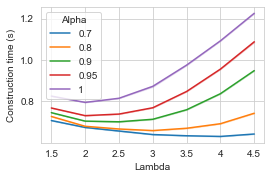

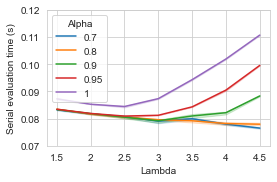

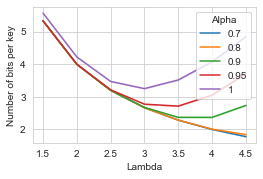

In [3]:
figsize=((4, 2.5))

df = read_csv('csv/bench_function.csv')

df = df[
    (df['Family'] == 'AceHash') 
    & df['Alpha'].isin(['0.7', '0.8', '0.9', '0.95', '1'])
    & (df['Parallel construct'] == '0')
    & (df['Multi-round partition'] == '1')
    & (df['Multi-slot search'] == '1')
    & (df['Multi-key evaluate'] == '1')
]

df['Number of bits per key'] = df['Number of bits'] / df['Number of keys']

plt.figure(figsize=figsize)
sns.lineplot(
    data=df,
    x='Lambda',
    y='Construction time (s)',
    hue='Alpha'
)

plt.figure(figsize=figsize)
sns.lineplot(
    data=df,
    x='Lambda',
    y='Serial evaluation time (s)',
    hue='Alpha'
)
plt.ylim((0.07, 0.12))


plt.figure(figsize=figsize)
sns.lineplot(
    data=df,
    x='Lambda',
    y='Number of bits per key',
    hue='Alpha'
)

<AxesSubplot:xlabel='Gamma', ylabel='Number of bits per key'>

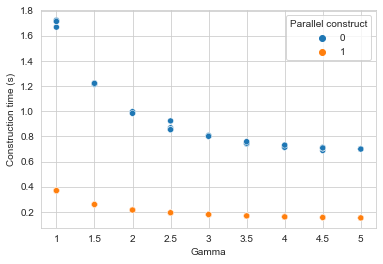

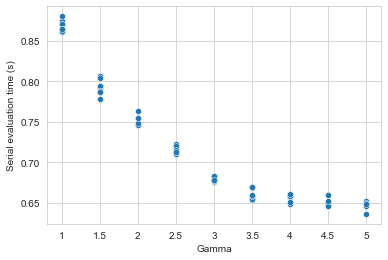

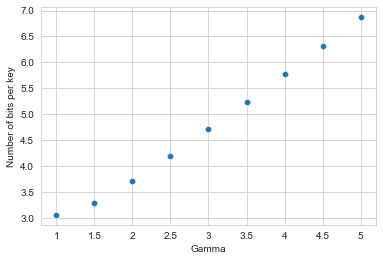

In [20]:
df = read_csv('csv/bench_function.csv')

df = df[
    (df['Family'] == 'BBHash')
]

df['Number of bits per key'] = df['Number of bits'] / df['Number of keys']

plt.figure()
sns.scatterplot(
    data=df,
    x='Gamma',
    y='Construction time (s)',
    hue='Parallel construct'
)

plt.figure()
sns.scatterplot(
    data=df,
    x='Gamma',
    y='Serial evaluation time (s)'
)

plt.figure()
sns.scatterplot(
    data=df,
    x='Gamma',
    y='Number of bits per key'
)

<AxesSubplot:xlabel='C', ylabel='Number of bits per key'>

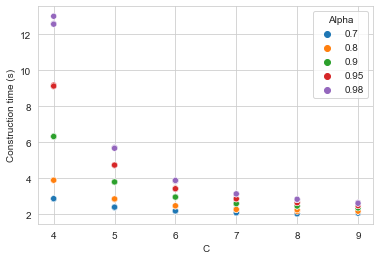

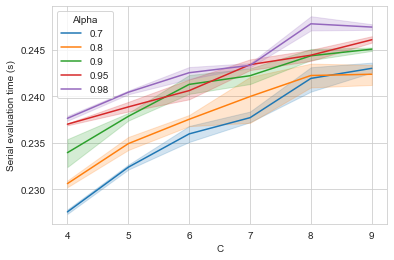

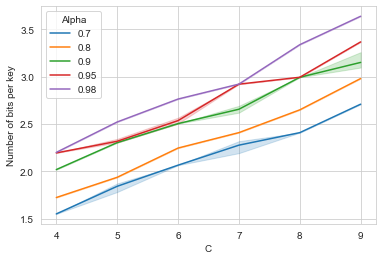

In [54]:
df = read_csv('csv/bench_function.csv')

df = df[
    (df['Family'] == 'PTHash')
    & df['Alpha'].isin(['0.7', '0.8', '0.9', '0.95', '0.98'])
    & (df['Encoder'] == 'dictionary-dictionary')
    & (df['Minimal'] == '0')
]

df['Number of bits per key'] = df['Number of bits'] / df['Number of keys']

plt.figure()
sns.scatterplot(
    data=df,
    x='C',
    y='Construction time (s)',
    hue='Alpha'
)

plt.figure()
sns.lineplot(
    data=df,
    x='C',
    y='Serial evaluation time (s)',
    hue='Alpha'
)

plt.figure()
sns.lineplot(
    data=df,
    x='C',
    y='Number of bits per key',
    hue='Alpha'
)